<center>
<h1><b>Lab 8</b></h1>
<h1>PHYS 580 - Computational Physics</h1>
<h2>Professor Molnar</h2>
</br>
<h3><b>Ethan Knox</b></h3>
<h4>https://www.github.com/ethank5149</h4>
<h4>ethank5149@gmail.com</h4>
</br>
</br>
<h3><b>October 22, 2020</b></h3>
<hr>
</center>

In [25]:
import numpy as np
from scipy.integrate import quad
from functools import partial
import matplotlib.pyplot as plt
from dask.distributed import Client

In [26]:
%run paths.py
%run integrands.py

In [27]:
def B_loop_top(_pos, _l, _R, _w):
    B_x = quad(partial(B_loop_top_x_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_y = quad(partial(B_loop_top_y_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_z = quad(partial(B_loop_top_z_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    return np.asarray([B_x, B_y, B_z])

def B_loop_bottom(_pos, _l, _R, _w):
    B_x = quad(partial(B_loop_bottom_x_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_y = quad(partial(B_loop_bottom_y_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_z = quad(partial(B_loop_bottom_z_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    return np.asarray([B_x, B_y, B_z])

def B_solenoid(_pos, _l, _R, _w):
    B_x = quad(partial(B_solenoid_x_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_y = quad(partial(B_solenoid_y_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    B_z = quad(partial(B_solenoid_z_integrand, *_pos, _l, _R, _w), 0, 1)[0]
    return np.asarray([B_x, B_y, B_z])

# Problem 1
The starter code ```loop.py``` provided uses the simple rectangular panel method of integration to compute the magnetic field $\mathbf{B}$ of a current loop (the Matlab code has two files ```loop.m``` and ```loop_calculate_field.m```). The loop is in the $x-y$ plane and is centered at the origin, just like in the setup discussed in class. (By the way, for this problem, the rectangular panel method is actually the same as the trapezoidal rule. Why?) Extend the programs (or create your own equivalent ones) to calculate the $\mathbf{B}$ field of two identically shaped parallel loops that share a common axis (the z-axis) and are situated symmetrically about the origin with their respective planes a distance $d$ apart. First, calculate the field when the loops carry equal currents in the same direction, which is the Helmholtz coil configuration that is known to produce a nearly uniform magnetic field at the center. Then, investigate what happens if equal currents are carried in the opposite directions.

In [28]:
l = 10
R = 5
w = 24
N = 50
n_quiver = 12

In [29]:
x = np.linspace(-R, R, n_quiver)
y = np.linspace(-R, R, n_quiver)
z = np.linspace(-l, l, n_quiver)
s = np.linspace(0, 1, N ** 2)
xx, yy, zz = np.meshgrid(x, y, z)

In [18]:
client = Client()
run_a = client.map(partial(   B_loop_top, _l=l, _R=R, _w=w), [(_1,_2,_3) for _1,_2,_3 in zip(x,y,z)])
run_b = client.map(partial(B_loop_bottom, _l=l, _R=R, _w=w), [(_1,_2,_3) for _1,_2,_3 in zip(x,y,z)])
results_a = np.asarray(client.gather(run_a))
results_b = np.asarray(client.gather(run_b))
parallel = (results_a + results_b).T
opposite = (results_a + results_b).T
client.close()

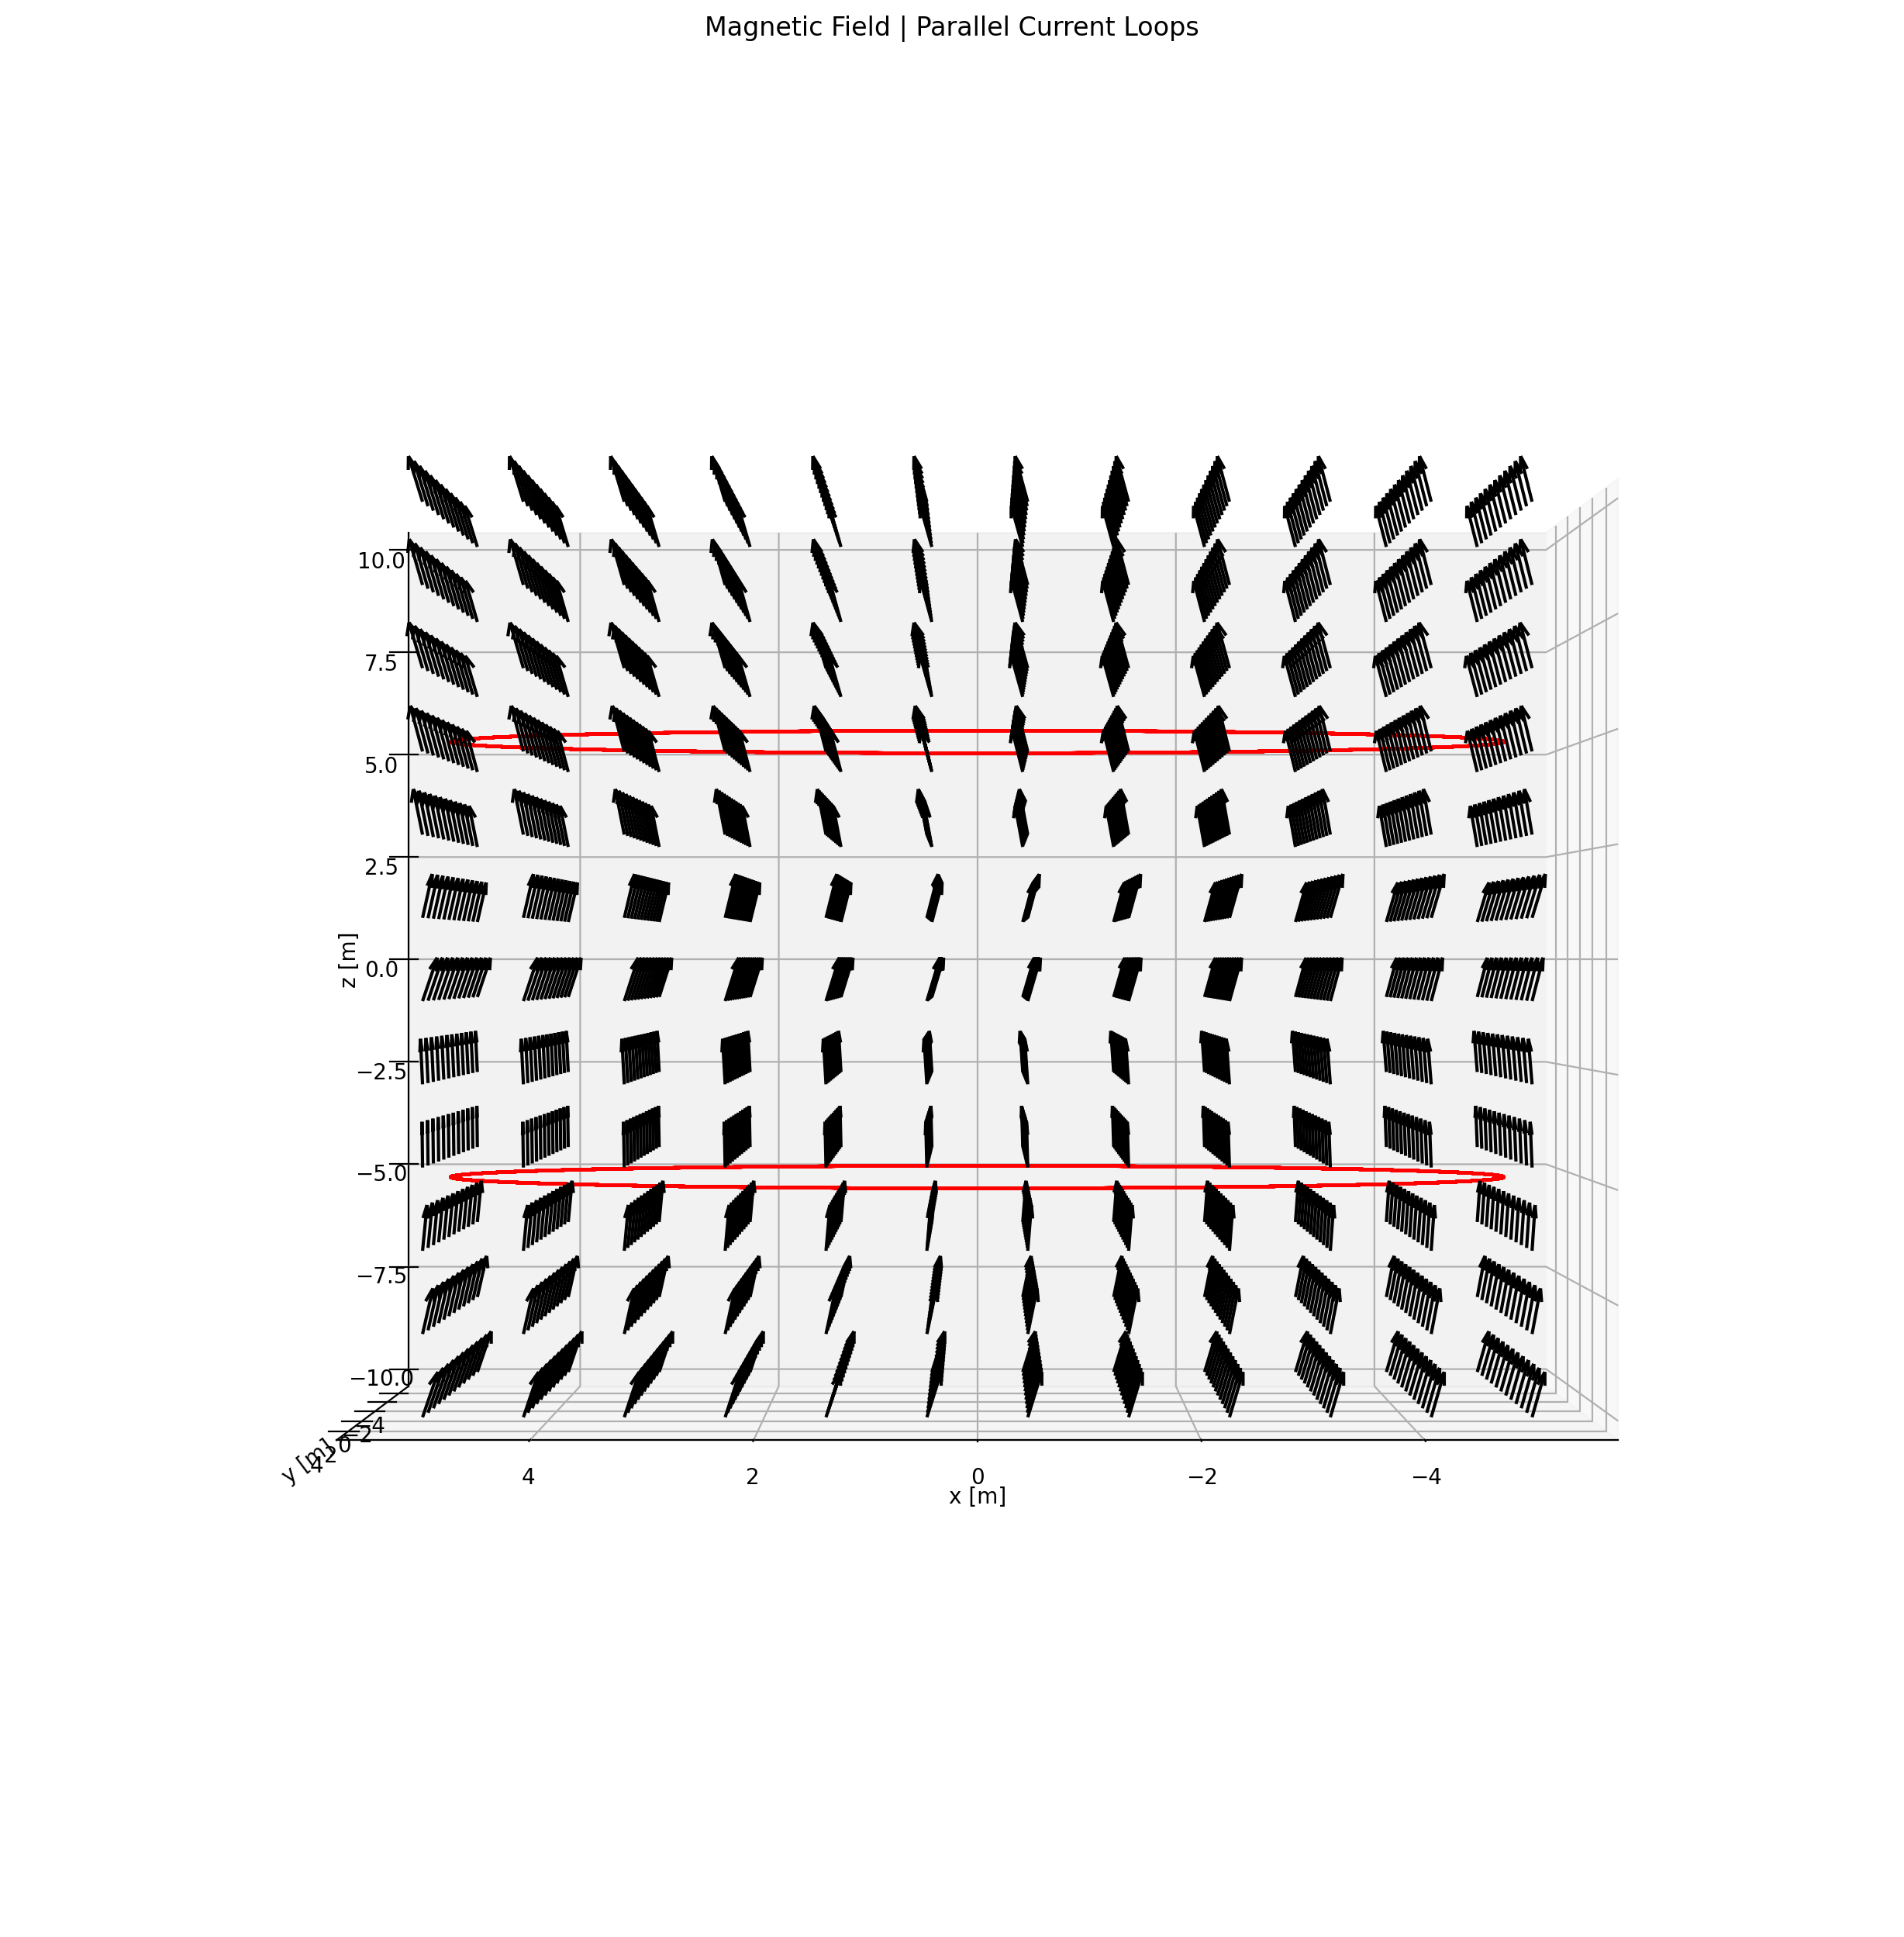

In [19]:
fig = plt.figure(figsize=(16, 16), dpi=200)
ax = fig.gca(projection='3d')
wire_a = ax.plot(*partial(path_loop_top, _l=l, _R=R, _w=w)(s), color='red')
wire_b = ax.plot(*partial(path_loop_bottom, _l=l, _R=R, _w=w)(s), color='red')
quiver = ax.quiver(xx, yy, zz, *np.vsplit(parallel, 3), color='k', normalize=True)

ax.set_title('Magnetic Field | Parallel Current Loops')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.view_init(0, 90)
plt.savefig('Problem_1a.png')

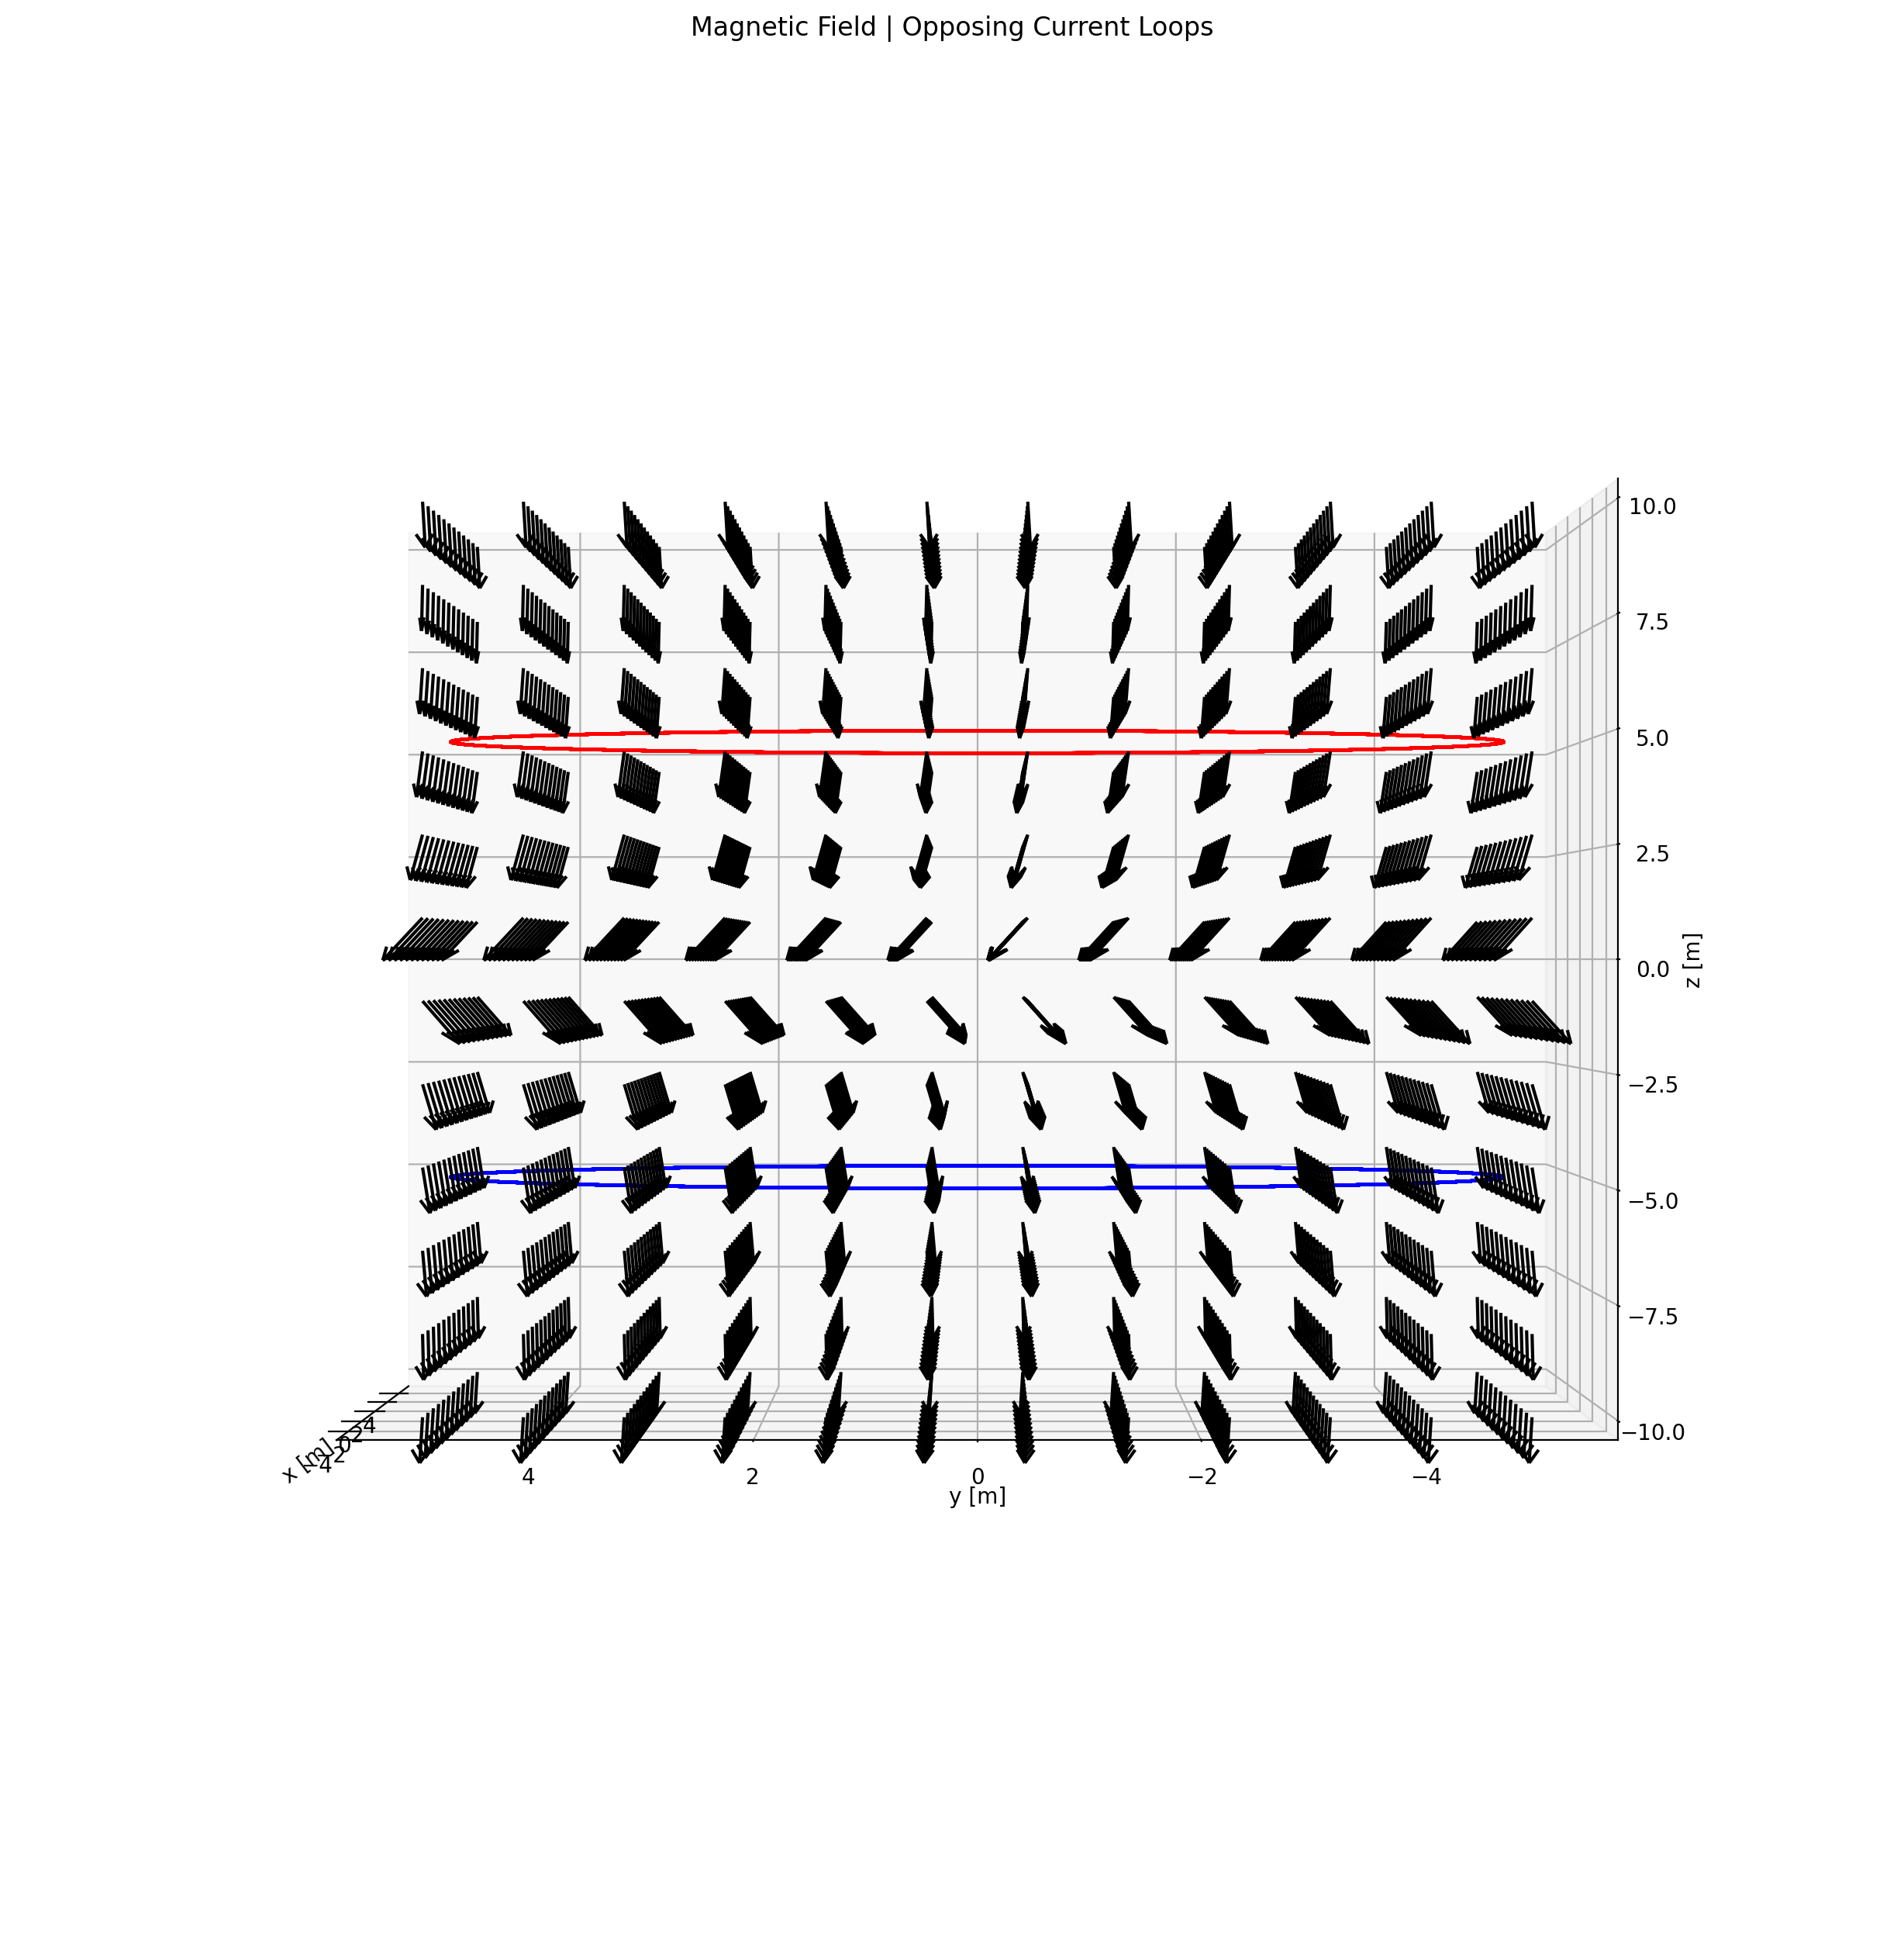

In [20]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.gca(projection='3d')
wire_a = ax.plot(*partial(path_loop_top, _l=l, _R=R, _w=w)(s), color='red')
wire_b = ax.plot(*partial(path_loop_bottom, _l=l, _R=R, _w=w)(s), color='blue')
quiver = ax.quiver(xx, yy, zz, *np.vsplit(opposite, 3), color='k', normalize=True)

ax.set_title('Magnetic Field | Opposing Current Loops')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.view_init(0, 180)
plt.savefig('Problem_1b.png')

# Problem 2
Extend your programs further to implement the same calculation for a helical coil of multiple loops (i.e., a current-carrying wire wrapped around a cylinder). The coil is centered at the origin, its axis coincides with the $z$ axis, and it has a given pitch $P$ (i.e., the location of the wire advances by distance $P$ in the axial direction as the angle of winding along the wire goes through $2\pi$). Using your program, calculate the magnetic field both inside and outside the coil for various lengths and numbers of winding, with the current set such that $\frac{\mu_0}{4\pi}=1$. Show results for at least one case with loose winding, illustrating how $\textbf{B}$ leaks through the coil, and a case with tight winding, showing how $\textbf{B}$ approaches the field of an ideal solenoid.

__Note:__ the analytic result for $\textbf{B}$ on the axis of an ideal (i.e., tightly wound) solenoid of radius $R$ extending along the $z$-axis from $z=-\frac{L}{2}$ to $\frac{L}{2}$ is:

$$\textbf{B}=\hat{e}_z\frac{\mu_0In}{2}\left(\frac{\frac{L}{2}+z}{\sqrt{\left(\frac{L}{2}+z\right)^2+R^2}}+\frac{\frac{L}{2}-z}{\sqrt{\left(\frac{L}{2}-z\right)^2+R^2}}\right)$$

where  $n$  is the winding number per unit length and the current  $I$  is counter-clockwise when viewed from above the $x$-$y$ plane. However, away from the axis, for example, at a point on the $x$ axis, $\textbf{B}$ is much harder to calculate or approximate analytically (especially when $x$ is of the same order as $R$).

In [21]:
client = Client()
run_tight = client.map(partial(B_solenoid, _l=l, _R=R,   _w=w), [(_1,_2,_3) for _1,_2,_3 in zip(x,y,z)])
run_loose = client.map(partial(B_solenoid, _l=l, _R=R, _w=w/3), [(_1,_2,_3) for _1,_2,_3 in zip(x,y,z)])
tight = np.asarray(client.gather(run_tight))
loose = np.asarray(client.gather(run_loose))
client.close()

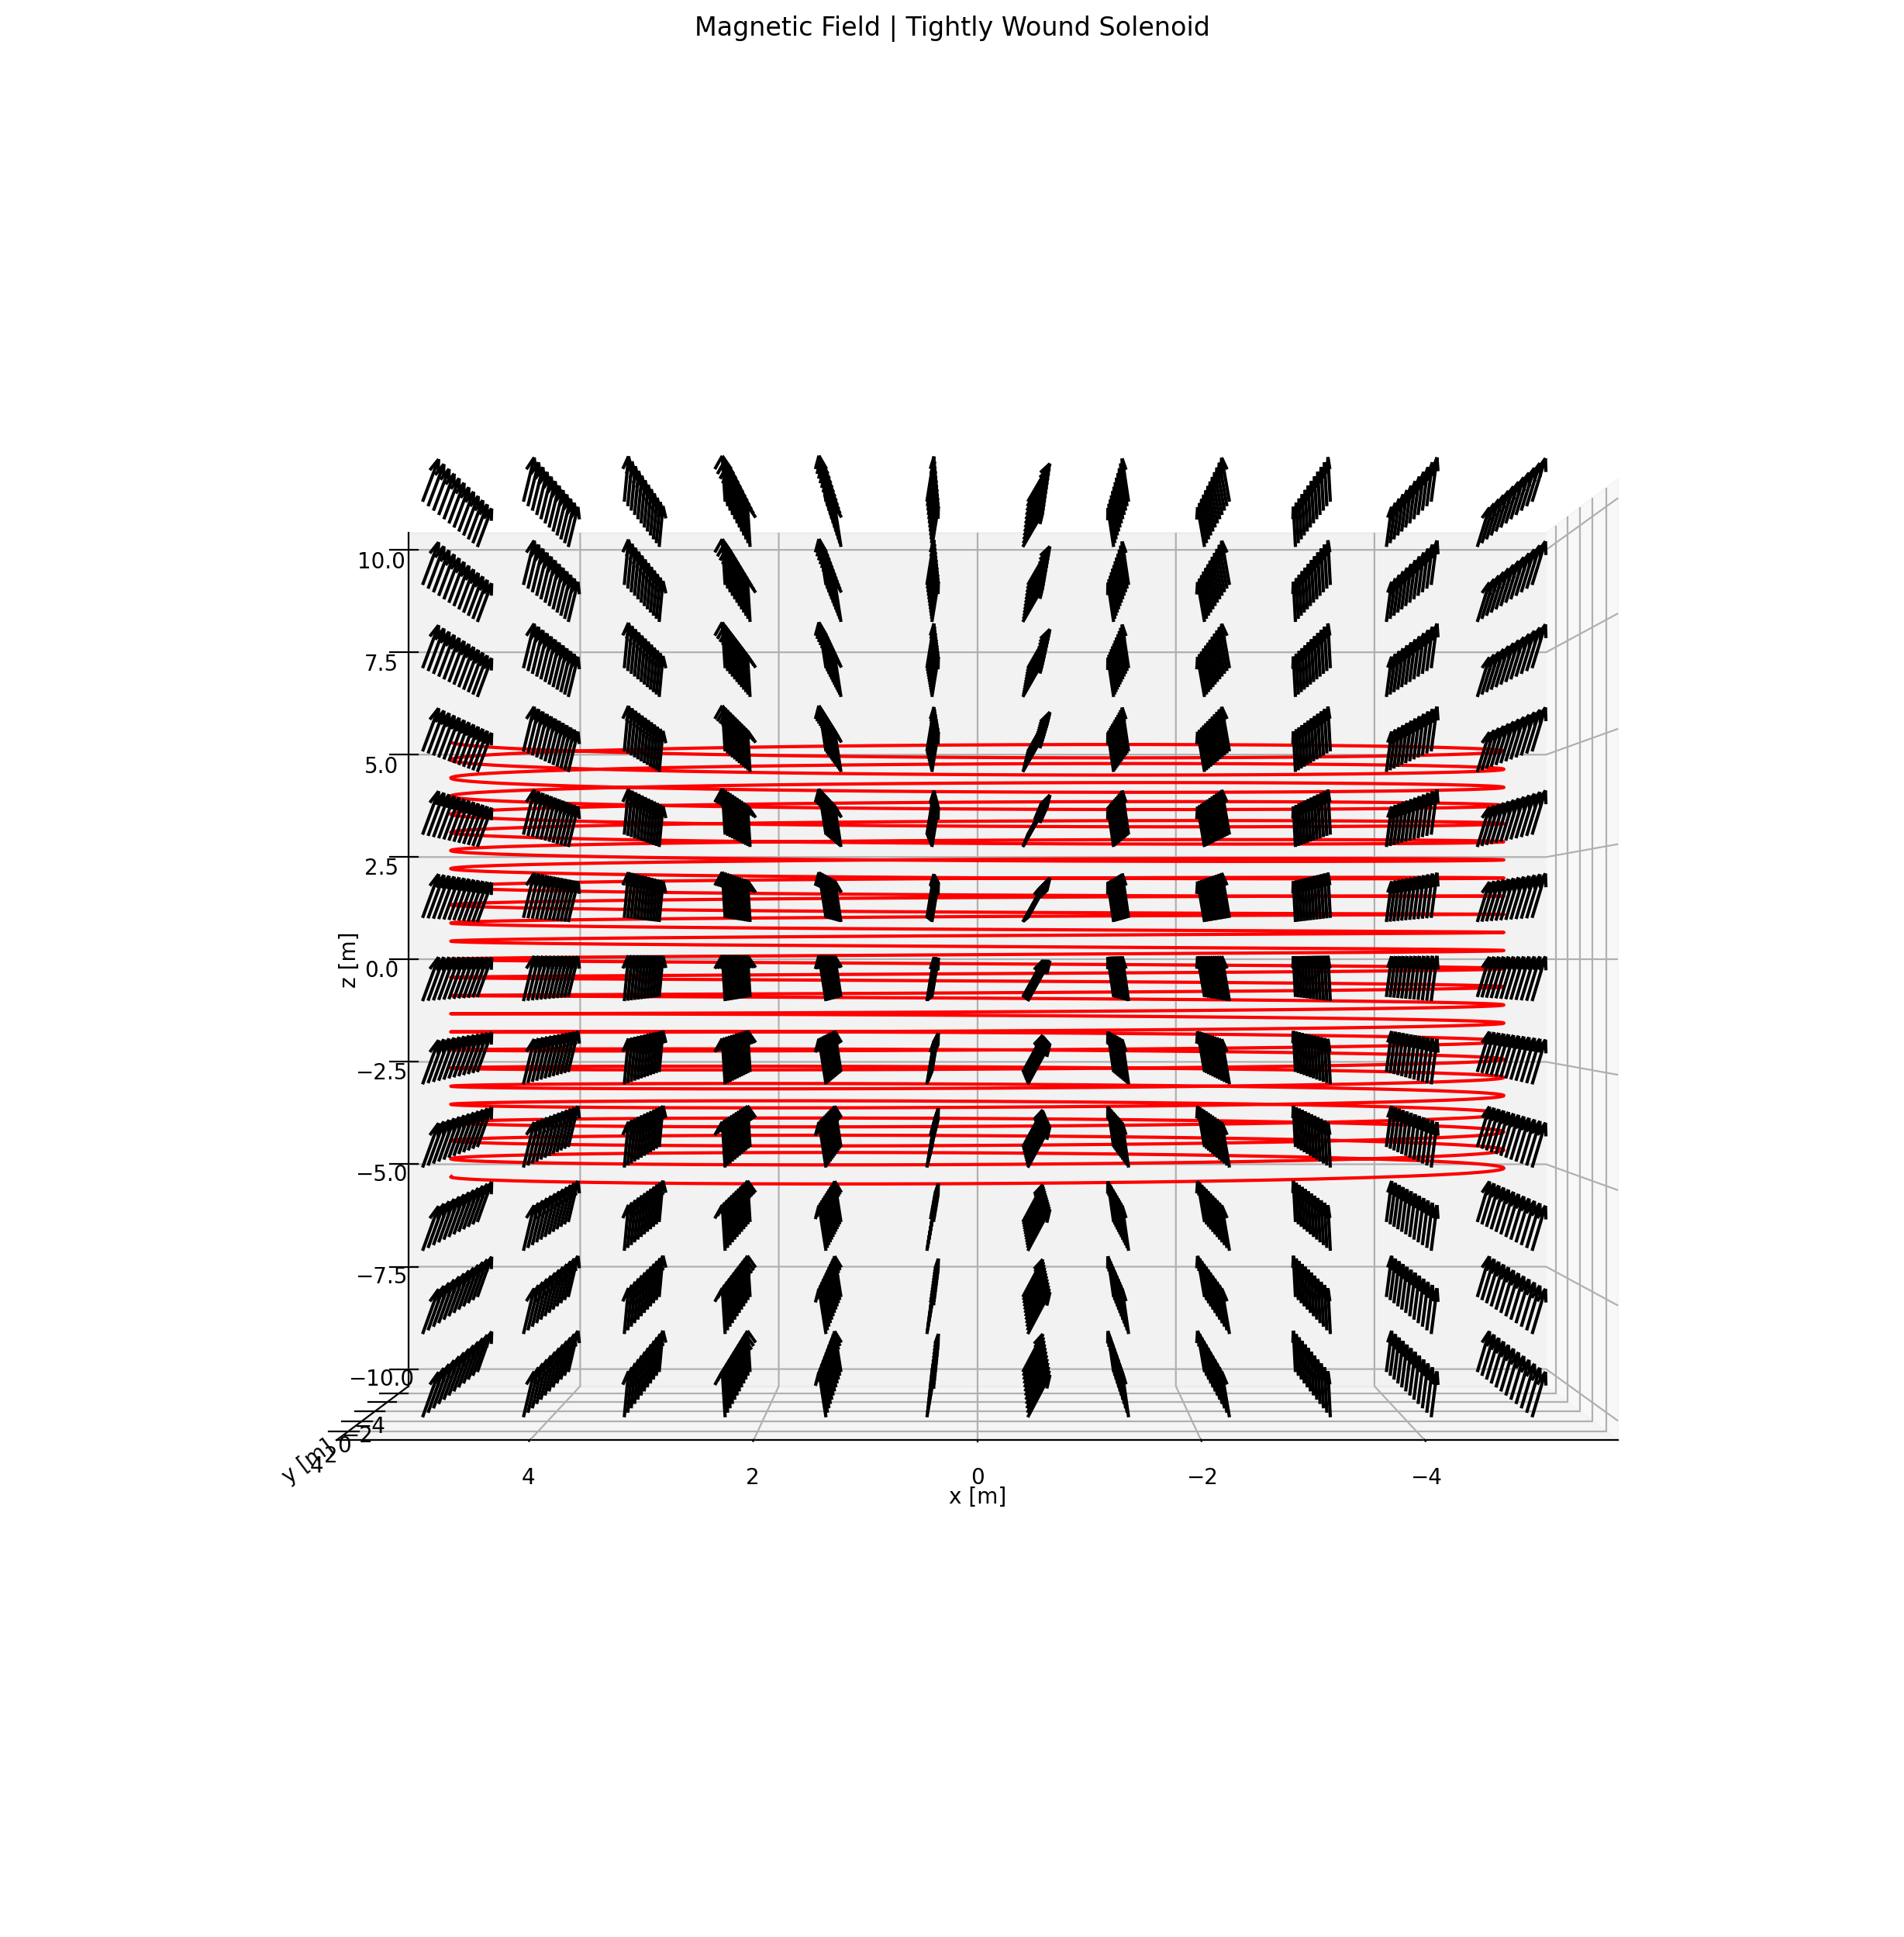

In [22]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.gca(projection='3d')
solenoid = ax.plot(*partial(path_solenoid, _l=l, _R=R, _w=w)(s), color='red')
quiver = ax.quiver(xx, yy, zz, *np.hsplit(tight, 3), color='k', normalize=True)

ax.set_title('Magnetic Field | Tightly Wound Solenoid')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.view_init(0, 90)
plt.savefig('Problem_2a.png')

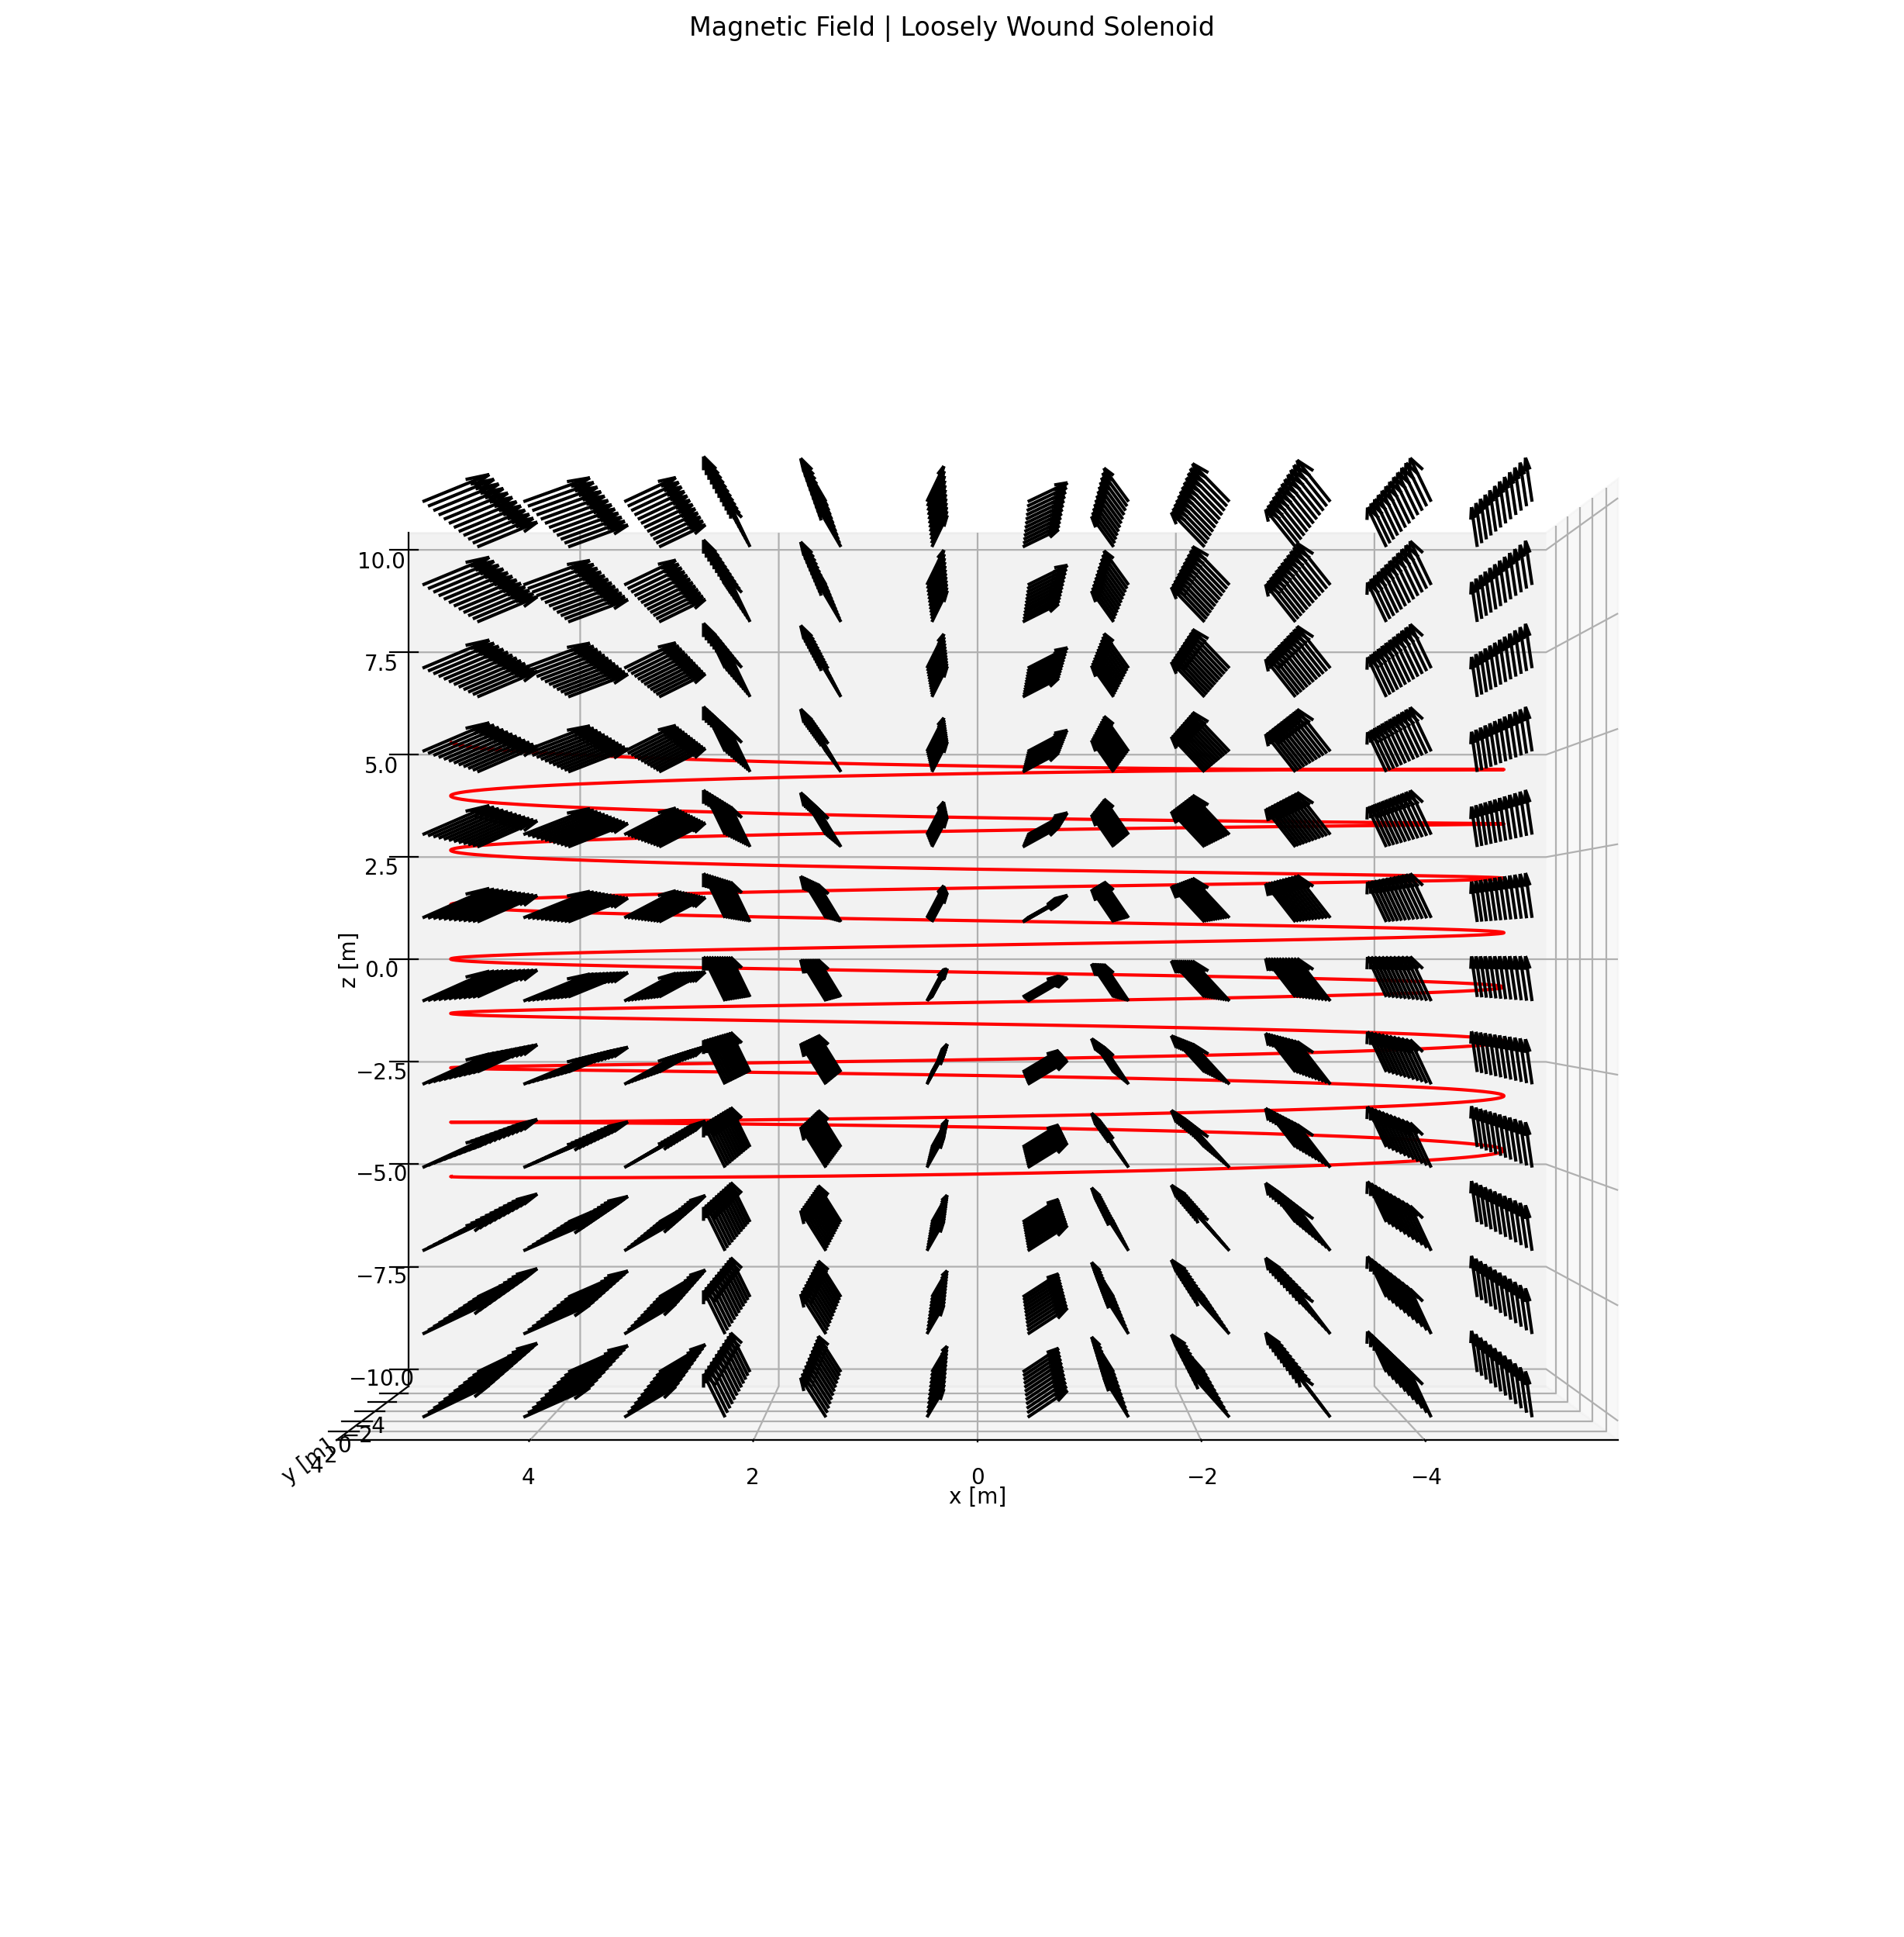

In [23]:
fig = plt.figure(figsize=(16,16), dpi=200)
ax = fig.gca(projection='3d')
solenoid = ax.plot(*partial(path_solenoid, _l=l, _R=R, _w=w/3)(s), color='red')
quiver = ax.quiver(xx, yy, zz, *np.hsplit(loose, 3), color='k', normalize=True)

ax.set_title('Magnetic Field | Loosely Wound Solenoid')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.view_init(0, 90)
plt.savefig('Problem_2b.png')

In [24]:
import sympy as sp
from sympy.vector import CoordSys3D
from sympy import sin, cos, symbols, Function, Integral, pi

R, x, y, z, s, t, d, L, w = symbols(r'R x y z s t d L \omega')
cx, cy, cz = Function('c_x')(s), Function('c_y')(s), Function('c_z')(s)
e = CoordSys3D('e')
r = x * e.i + y * e.j + z * e.k

path_loop_top = R * cos(2 * pi * w * s) * e.i + R * sin(2 * pi * w * s) * e.j + d * e.k / 2
path_loop_bottom = R * cos(2 * pi * w * s) * e.i + R * sin(2 * pi * w * s) * e.j - d * e.k / 2
path_loop_bottom_reversed = R * cos(2 * pi * w * (1 - s)) * e.i + R * sin(2 * pi * w * (1 - s)) * e.j - d * e.k / 2
path_solenoid = R * cos(2 * pi * w * s) * e.i + R * sin(2 * pi * w * s) * e.j + L * (2 * s - 1) * e.k / 2

B_loop_top = Integral(path_loop_top.diff(s).cross(r - path_loop_top) / (r - path_loop_top).magnitude() ** 3, (s, 0, 1))
B_loop_bottom = Integral(path_loop_bottom.diff(s).cross(r - path_loop_bottom) / (r - path_loop_bottom).magnitude() ** 3, (s, 0, 1))
B_loop_bottom_reversed = Integral(path_loop_bottom_reversed.diff(s).cross(r - path_loop_bottom_reversed) / (r - path_loop_bottom_reversed).magnitude() ** 3, (s, 0, 1))

B_solenoid = Integral(path_solenoid.diff(s).cross(r - path_solenoid) / (r - path_solenoid).magnitude() ** 3, (s, 0, 1))
B_loop = B_loop_top + B_loop_bottom
B_loop_opp = B_loop_top + B_loop_bottom_reversed